In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
%matplotlib inline

##  Load Data

In [2]:
data_set = np.load('imdb_word_emb.npz')
X_train = data_set['X_train']
y_train = data_set['y_train']
X_test = data_set['X_test']
y_test = data_set['y_test']

In [3]:
y_convert = []
for i in y_train:
    if i == 0:
        ans = np.array([1.0, 0.0])
    else:
        ans = np.array([0.0, 1.0])
    y_convert.append(ans)
y_c = np.array(y_convert)

In [4]:
y_convert_test = []
for i in y_test:
    if i == 0:
        ans = np.array([1.0, 0.0])
    else:
        ans = np.array([0.0, 1.0])
    y_convert_test.append(ans)
yct = np.array(y_convert_test)

In [5]:
def random():
    
    num = len(X_train)
    idx = np.random.choice(num, size = batch_size, replace=False)
    
    x_batch = X_train[idx, :]
    y_batch = y_c[idx, :]

    return x_batch, y_batch

## Models

In [6]:
sess = tf.InteractiveSession()

In [7]:
# Parameters
learning_rate = 0.0001
#training_iters = 200000
batch_size = 200
display = 100

# Network Parameters
n_input = 128 
n_steps = 80 # timesteps,

n_hidden = 512 
n_classes = 2 

In [10]:
'''x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'in': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'in' : tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}'''

'x = tf.placeholder("float", [None, n_steps, n_input])\ny = tf.placeholder("float", [None, n_classes])\n\nweights = {\n    \'in\': tf.Variable(tf.random_normal([n_input, n_hidden])),\n    \'out\': tf.Variable(tf.random_normal([n_hidden, n_classes]))\n}\nbiases = {\n    \'in\' : tf.Variable(tf.random_normal([n_hidden])),\n    \'out\': tf.Variable(tf.random_normal([n_classes]))\n}'

In [8]:
def reset():
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_steps, n_input])
    y = tf.placeholder("float", [None, n_classes])

    weights = {
        'in': tf.Variable(tf.random_normal([n_input, n_hidden])),
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'in' : tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    return x, y , weights, biases

In [9]:
def rnn_cell():
    return rnn.BasicRNNCell(n_hidden, reuse=tf.get_variable_scope().reuse)

In [10]:
def gru_cell():
    return rnn.GRUCell(n_hidden, reuse=tf.get_variable_scope().reuse)

In [11]:
def lstm_cells():
    return rnn.LSTMCell(n_hidden, reuse=tf.get_variable_scope().reuse,  forget_bias=1.0)

In [12]:
def RNN_Model(x, weights, biases, kind, hidden_layer):

   
    x_or = x
    '''x = tf.reshape(x, [-1, n_input])
    x_in = tf.matmul(x, weights['in'] +biases['in'])
    x_in = tf.reshape(x_in, [-1,n_steps, n_hidden])
    x = tf.unstack(x_in, n_steps, 1)'''
    
    if(kind == 'LSTM'): 
        stacked_cell = rnn.MultiRNNCell([lstm_cells() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    if(kind == 'GRU'):
        stacked_cell = rnn.MultiRNNCell([gru_cell() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    else:
        stacked_cell = rnn.MultiRNNCell([rnn_cell() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    
    init_state = stacked_cell.zero_state(batch_size, tf.float32)
   
    outputs = []
    state = init_state
    with tf.variable_scope("RNN"):
        for time_step in range(n_steps):
            if time_step > 0: tf.get_variable_scope().reuse_variables()
            (cell_output, state) = stacked_cell(x[:, time_step, :], state)
            outputs.append(cell_output)


    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [13]:
x, y , weights, biases = reset()
pred = RNN_Model(x, weights, biases, 'RNN', 1) # GRU ,LSTM , default: RNN

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))


#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cost)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables


In [24]:
def running():
    acc_test = 0.0 
    accuracy_train = []
    accuracy_test = []
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        step = 1
        while(1):
            
            if len(accuracy_test)>2 and ((accuracy_test[-1] - accuracy_test[-2]) <0.001) and accuracy_test[-1] >= 0.9: #stopping
                break
            
            else: 
                batch_x, batch_y = random()

                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
                if step % display == 0:

                    acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
                    accuracy_train.append(acc)

                    loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
                    print("IterSize: " + str(step*batch_size) + ", Loss= " + "{:.6f}".format(loss) + ", Training Accuracy = " + \
                          "{:.5f}".format(acc))
                    dx = 0
                    acc = []
                    for i in range(len(y_test)//batch_size):

                        test_data = X_test[dx:dx+batch_size]
                        test_label = yct[dx:dx+batch_size]
                        dx = dx+batch_size
                        acc.append(sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

                    acc_test =  np.mean(acc)
                    accuracy_test.append(acc_test)

                    print("Testing Accuracy:", accuracy_test)
                step += 1
                
        print("Finished!")
    
    return accuracy_train, accuracy_test
    

In [22]:
basic_train, basic_test = running()

IterSize: 20000, Loss= 0.407625, Training Accuracy = 0.85500
Testing Accuracy: [0.85319996]
IterSize: 40000, Loss= 0.398801, Training Accuracy = 0.87500
Testing Accuracy: [0.85319996, 0.86363995]
IterSize: 60000, Loss= 0.334343, Training Accuracy = 0.88000
Testing Accuracy: [0.85319996, 0.86363995, 0.87532002]
IterSize: 80000, Loss= 0.385596, Training Accuracy = 0.88500
Testing Accuracy: [0.85319996, 0.86363995, 0.87532002, 0.88084006]
IterSize: 100000, Loss= 0.156380, Training Accuracy = 0.94000
Testing Accuracy: [0.85319996, 0.86363995, 0.87532002, 0.88084006, 0.88915992]
IterSize: 120000, Loss= 0.330930, Training Accuracy = 0.90500
Testing Accuracy: [0.85319996, 0.86363995, 0.87532002, 0.88084006, 0.88915992, 0.89240003]
IterSize: 140000, Loss= 0.304382, Training Accuracy = 0.90500
Testing Accuracy: [0.85319996, 0.86363995, 0.87532002, 0.88084006, 0.88915992, 0.89240003, 0.89804]
IterSize: 160000, Loss= 0.133537, Training Accuracy = 0.95000
Testing Accuracy: [0.85319996, 0.86363995,

In [44]:
n_hidden = 128
x, y , weights, biases = reset()
pred = RNN_Model(x, weights, biases, 'GRU', 2) # GRU ,LSTM , default: RNN
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [45]:
GRU_train, GRU_test = running()

IterSize: 20000, Loss= 0.566882, Training Accuracy = 0.79000
Testing Accuracy: [0.73167998]
IterSize: 40000, Loss= 0.584722, Training Accuracy = 0.71000
Testing Accuracy: [0.73167998, 0.74355996]
IterSize: 60000, Loss= 0.557565, Training Accuracy = 0.72000
Testing Accuracy: [0.73167998, 0.74355996, 0.75071996]
IterSize: 80000, Loss= 0.566312, Training Accuracy = 0.72500
Testing Accuracy: [0.73167998, 0.74355996, 0.75071996, 0.75720006]
IterSize: 100000, Loss= 0.545033, Training Accuracy = 0.76500
Testing Accuracy: [0.73167998, 0.74355996, 0.75071996, 0.75720006, 0.76200002]
IterSize: 120000, Loss= 0.560493, Training Accuracy = 0.72500
Testing Accuracy: [0.73167998, 0.74355996, 0.75071996, 0.75720006, 0.76200002, 0.76628]
IterSize: 140000, Loss= 0.522158, Training Accuracy = 0.76000
Testing Accuracy: [0.73167998, 0.74355996, 0.75071996, 0.75720006, 0.76200002, 0.76628, 0.77128005]
IterSize: 160000, Loss= 0.545510, Training Accuracy = 0.74500
Testing Accuracy: [0.73167998, 0.74355996, 0.

In [35]:
n_hidden = 128
x, y , weights, biases = reset()
pred = RNN_Model(x, weights, biases, 'LSTM', 2) # GRU ,LSTM , default: RNN
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [36]:
LSTM_train, LSTM_test = running() 

IterSize: 20000, Loss= 0.800172, Training Accuracy = 0.61000
Testing Accuracy: [0.58832002]
IterSize: 40000, Loss= 0.694092, Training Accuracy = 0.62500
Testing Accuracy: [0.58832002, 0.64763999]
IterSize: 60000, Loss= 0.714619, Training Accuracy = 0.69000
Testing Accuracy: [0.58832002, 0.64763999, 0.70943999]
IterSize: 80000, Loss= 0.497042, Training Accuracy = 0.78000
Testing Accuracy: [0.58832002, 0.64763999, 0.70943999, 0.76836008]
IterSize: 100000, Loss= 0.447354, Training Accuracy = 0.80500
Testing Accuracy: [0.58832002, 0.64763999, 0.70943999, 0.76836008, 0.84640002]
IterSize: 120000, Loss= 0.377311, Training Accuracy = 0.85000
Testing Accuracy: [0.58832002, 0.64763999, 0.70943999, 0.76836008, 0.84640002, 0.87612003]
IterSize: 140000, Loss= 0.292559, Training Accuracy = 0.88000
Testing Accuracy: [0.58832002, 0.64763999, 0.70943999, 0.76836008, 0.84640002, 0.87612003, 0.87988007]
IterSize: 160000, Loss= 0.285386, Training Accuracy = 0.88000
Testing Accuracy: [0.58832002, 0.647639

In [26]:
def plot_accuracy(train, test, word):
    
    
    for i in range(len(train)):
        train[i] = 1 - train[i]
    
    for i in range(len(test)):
        test[i] = 1 - test[i]
        
    plt.plot(range(len(train)), train,'b')
    plt.plot(range(len(test)), test,'r')
    plt.ylabel('Error rate')
    plt.title(word)
    plt.show()

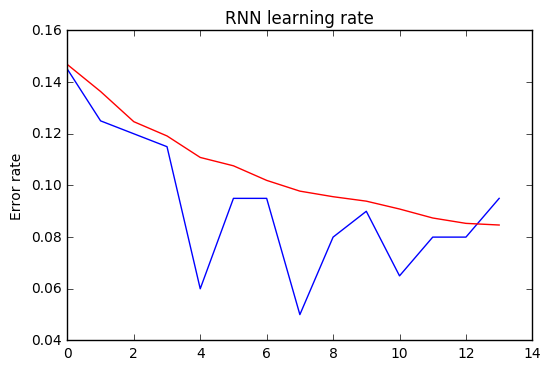

In [47]:
plot_accuracy(basic_train, basic_test, 'RNN learning rate')

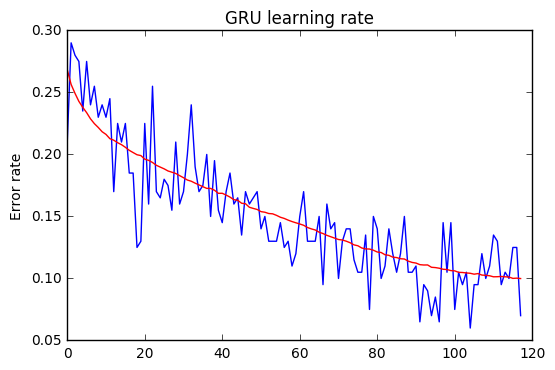

In [48]:
plot_accuracy(GRU_train, GRU_test, 'GRU learning rate')

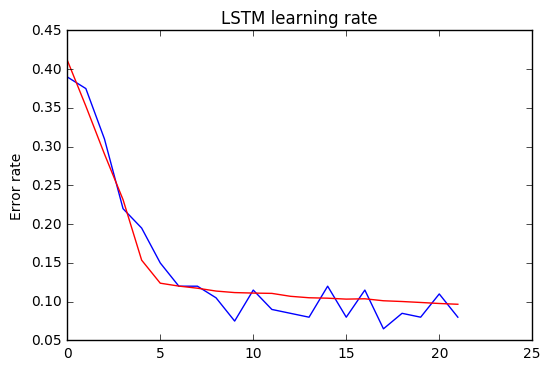

In [49]:
plot_accuracy(LSTM_train, LSTM_test, 'LSTM learning rate')